In [1]:
!wget http://snap.stanford.edu/data/cit-HepPh.txt.gz -O CitationGraph.txt.gz
!gunzip CitationGraph.txt.gz

--2024-11-15 21:46:16--  http://snap.stanford.edu/data/cit-HepPh.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1664504 (1.6M) [application/x-gzip]
Saving to: 'CitationGraph.txt.gz'

CitationGraph.txt.g 100%[===================>]   1.59M  6.45MB/s    in 0.2s    

2024-11-15 21:46:16 (6.45 MB/s) - 'CitationGraph.txt.gz' saved [1664504/1664504]



In [2]:
!wget http://snap.stanford.edu/data/cit-HepPh-dates.txt.gz -O CitationDates.txt.gz
!gunzip CitationDates.txt.gz

--2024-11-15 21:46:18--  http://snap.stanford.edu/data/cit-HepPh-dates.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96569 (94K) [application/x-gzip]
Saving to: 'CitationDates.txt.gz'

CitationDates.txt.g 100%[===================>]  94.31K  --.-KB/s    in 0.08s   

2024-11-15 21:46:19 (1.23 MB/s) - 'CitationDates.txt.gz' saved [96569/96569]



In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random


In [5]:
# Get basic info about the nodes of the graph

graph = nx.DiGraph()
reverse_graph = nx.DiGraph()


max_id = 0
min_id = 1e9

nodes = set()

edge_list = []

with open("CitationGraph.txt", "r") as f:

    lines = f.readlines()
    lines = [line.strip("\n") for line in lines[4:150004]]

    for line in lines:
        a, b = line.split()
        a = int(a)
        b = int(b)

        max_id = max(max_id, a, b)
        min_id = min(min_id, a, b)

        nodes.add(a)
        nodes.add(b)

        edge_list.append((a, b))

nodes = list(nodes)
nodes.sort()
graph.add_nodes_from(nodes)
reverse_graph.add_nodes_from(nodes)
num_nodes = len(nodes)

for pair in edge_list:
    # if pair[0] == pair[1]:
    #     continue
    graph.add_edge(pair[0], pair[1])
    reverse_graph.add_edge(pair[1], pair[0])


num_edges = graph.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

max_id

Number of nodes: 19780
Number of edges: 150000


9912552

In [6]:
model = tf.keras.models.load_model('/kaggle/input/node2vec/keras/default/1/embeddings_2.keras')
node_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print(node_embeddings.shape)

(19780, 100)


In [7]:
embeddings = np.array(node_embeddings)
embeddings.shape

(19780, 100)

In [8]:
import json

with open("/kaggle/input/node-id/node_id.json", "r") as f:
    node_to_id = json.load(f)

len(node_to_id)

19780

In [9]:
date_node = []
node_dates = {}
node_dates_max = {}

with open("CitationDates.txt", "r") as f:
    lines = f.readlines()
    lines = [line.strip("\n") for line in lines[1:]]

    for line in lines:
        a, b = line.split()
        if(len(a) > 7):
             a = a[2:]
        a = int(a.lstrip('0'))
        if not graph.has_node(a):
            if str(a)[:2] == "11":
                a = int(str(a)[2:])
            if not graph.has_node(a):
                continue
        # date_node.append((b, a))
        if(node_dates.get(a) == None):
            node_dates[a] = b
            node_dates_max[a] = b
        else:
            node_dates[a] = min(node_dates[a], b)
            node_dates_max[a] = max(node_dates_max[a], b)

for node in node_dates:
    date_node.append((node_dates[node], node))

for node in graph.nodes():              # If the date of a particular paper is not in the file, we set the date to be something greater than the latest paper
    if node_dates.get(node) == None:
        node_dates[node] = "1992-01-01"
        node_dates_max[node] = "2002-04-01"
        date_node.append((node_dates[node], node))
        

date_node.sort()
print(len(date_node))
cnt = 0


19780


In [10]:
def lower_bound(date):
    l = 0
    r = len(date_node)

    while l != r:
        mid = int((l+r)/2)
        if(date_node[mid][0] >= date):
            r = mid
        else:
            l = mid + 1
    return l


In [11]:
time_graph = nx.DiGraph()
time_reverse_graph = nx.DiGraph()

def add_edges(start_date, end_date):
    start_idx = lower_bound(start_date)

    for i in range(start_idx, len(date_node)):
        if(date_node[i][0] > end_date):
            break
        # print(start_date, end_date, )
        node = date_node[i][1]

        if node not in graph.nodes():
            continue
        time_graph.add_node(node)
        time_reverse_graph.add_node(node)

        for e in graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(node, e)
                time_reverse_graph.add_edge(e, node)

        for e in reverse_graph.neighbors(node):
            if time_graph.has_node(e):
                time_graph.add_edge(e, node)
                time_reverse_graph.add_edge(node, e)

[Text(0, 0, '1,236'),
 Text(0, 0, '2,378'),
 Text(0, 0, '4,034'),
 Text(0, 0, '6,020'),
 Text(0, 0, '8,267'),
 Text(0, 0, '10,677'),
 Text(0, 0, '13,083'),
 Text(0, 0, '15,525'),
 Text(0, 0, '17,679'),
 Text(0, 0, '19,531'),
 Text(0, 0, '19,780')]

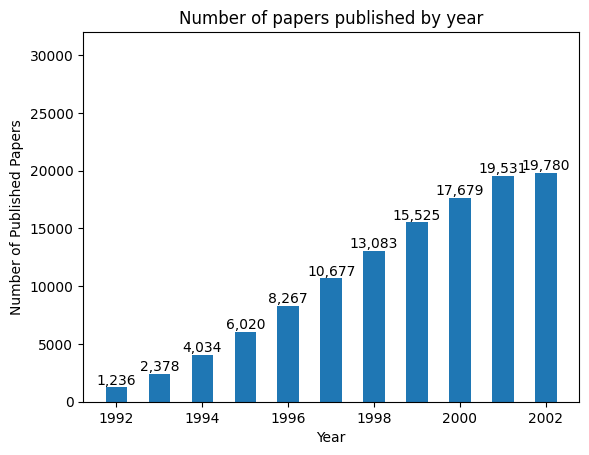

In [75]:
time_graph = nx.DiGraph()

y_val = [0 for _ in range(11)]
x_val = [i + 1992 for i in range(11)]
y_val2 = [0 for _ in range(11)]

for i in range(1992, 2003):
    add_edges(str(i)+'-01-01', str(i)+'-12-31')
    y_val2[i - 1992] = time_graph.number_of_nodes()

fig, axs = plt.subplots()
ax = axs
bar_container = ax.bar(x_val, y_val2, width=0.5)
ax.set(xlabel='Year', ylabel='Number of Published Papers', title='Number of papers published by year', ylim=(0, 32000))
ax.bar_label(bar_container, fmt='{:,.0f}')

Papers upto the year 1999 will be part of our training data and the following will be used for testing

In [12]:
import time

def date_to_num(dt):
    date_format = "%Y-%m-%d"
    a = time.mktime(time.strptime(dt, date_format))
    return a

date_array = np.zeros(len(node_dates) * 2)

id = 0

for dt in node_dates.values():
    date_array[id] = date_to_num(dt)
    id+=1

for dt in node_dates_max.values():
    date_array[id] = date_to_num(dt)
    id+=1

mean = np.mean(date_array)
dev = np.std(date_array)
date_array = (date_array - mean)/dev


In [13]:
def edge_to_vec(edge):
    curr = np.zeros(204)
    
    a = node_to_id[str(edge[0])]
    b = node_to_id[str(edge[1])]

    curr[:100] = embeddings[a]
    curr[100] = (date_to_num(node_dates[edge[0]]) - mean) / dev
    curr[101] = (date_to_num(node_dates_max[edge[0]]) - mean) / dev

    curr[102:202] = embeddings[b]
    curr[202] = (date_to_num(node_dates[edge[1]]) - mean) / dev
    curr[203] = (date_to_num(node_dates_max[edge[1]]) - mean) / dev

    return curr

In [20]:
time_graph = nx.DiGraph()

add_edges('1992-00-00', '1999-13-32')

time_graph.number_of_edges()

96103

In [21]:
cnt = 0

for node in time_graph.nodes():
    if not time_graph.has_edge(node, node):
        cnt += 1
cnt

15514

In [22]:
time_graph.number_of_nodes()

15525

In [23]:
x_train = np.zeros((3*time_graph.number_of_edges()+cnt, 204))
y_train = np.zeros(3*time_graph.number_of_edges()+cnt)

id = 0

for node in time_graph.nodes():
    if not time_graph.has_edge(node, node):
        x_train[id] = edge_to_vec((node, node))
        y_train[id] = 0
        id+=1

nodes = time_graph.nodes()

for edge in time_graph.edges():

    if id % 10000 ==0:
        print(id)

    x_train[id] = edge_to_vec(edge)
    y_train[id] = 1
    id+=1

    c = np.random.choice(nodes, 1)[0]

    while c in time_graph.successors(edge[0]):
        c = np.random.choice(nodes, 1)[0]


    x_train[id] = edge_to_vec((edge[0], c))
    y_train[id] = 0
    id+=1

    c = np.random.choice(nodes, 1)[0]

    while c in time_graph.predecessors(edge[1]):
        c = np.random.choice(nodes, 1)[0]

    x_train[id] = edge_to_vec((c, edge[1]))
    y_train[id] = 0
    id+=1

x_train.shape

    

40000
70000
100000
130000
160000
190000
220000
250000
280000


(303823, 204)

In [14]:
time_graph = nx.DiGraph()

add_edges('2000-00-00', '2003-13-32')

time_graph.number_of_edges()

12612

In [15]:
cnt = 0

for node in time_graph.nodes():
    if not time_graph.has_edge(node, node):
        cnt += 1
cnt

4248

In [16]:
x_test = np.zeros((3*time_graph.number_of_edges()+cnt, 204))
y_test = np.zeros(3*time_graph.number_of_edges()+cnt)

id = 0

for node in time_graph.nodes():
    if not time_graph.has_edge(node, node):
        x_test[id] = edge_to_vec((node, node))
        y_test[id] = 0
        id+=1

nodes = graph.nodes()

for edge in time_graph.edges():

    if id % 10000 ==0:
        print(id)

    x_test[id] = edge_to_vec(edge)
    y_test[id] = 1
    id+=1

    c = np.random.choice(nodes, 1)[0]

    while graph.has_edge(edge[0], c):
        c = np.random.choice(nodes, 1)[0]
        
    x_test[id] = edge_to_vec((edge[0], c))
    y_test[id] = 0
    id+=1

    c = np.random.choice(nodes, 1)[0]

    while graph.has_edge(c, edge[1]):
        c = np.random.choice(nodes, 1)[0]

    x_test[id] = edge_to_vec((c, edge[1]))
    y_test[id] = 0
    id+=1

x_test.shape

    

30000


(42084, 204)

In [24]:
lr = 0.005
num_epochs = 15
batch = 4096

In [25]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(256, activation='relu', input_shape=(204,)), 
                                    tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(128, activation='relu'),
                                   tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch, validation_data=(x_test, y_test))

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.7583 - loss: 0.4235 - val_accuracy: 0.9074 - val_loss: 0.2283
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9258 - loss: 0.1913 - val_accuracy: 0.9360 - val_loss: 0.1623
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9371 - loss: 0.1603 - val_accuracy: 0.9379 - val_loss: 0.1585
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9400 - loss: 0.1532 - val_accuracy: 0.9412 - val_loss: 0.1521
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9428 - loss: 0.1468 - val_accuracy: 0.9434 - val_loss: 0.1466
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9441 - loss: 0.1436 - val_accuracy: 0.9366 - val_loss: 0.1624
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9465 - loss: 0.1383 - val_accuracy: 0.9424 - val_loss: 0.1550
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9468 - loss: 0.1368 - val_accuracy: 0.9405 - val_los

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        52,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,253 (3.99 MB)

 Trainable params: 348,417 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 696,836 (2.66 MB)

In [34]:
x_train2 = x_train.copy()

for i in range(x_train2.shape[0]):
    x_train2[i, 100] = 0
    x_train2[i, 101] = 0
    x_train2[i, 202] = 0
    x_train2[i, 203] = 0

x_test2 = x_test.copy()

for i in range(x_test2.shape[0]):
    x_test2[i, 100] = 0
    x_test2[i, 101] = 0
    x_test2[i, 202] = 0
    x_test2[i, 203] = 0

In [35]:
model2 = tf.keras.models.Sequential([tf.keras.layers.Dense(256, activation='relu', input_shape=(204,)), 
                                    tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(128, activation='relu'),
                                   tf.keras.layers.Dense(1, activation='sigmoid')])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [36]:
history2 = model2.fit(x_train2, y_train, epochs=num_epochs, batch_size=batch, validation_data=(x_test2, y_test))

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7475 - loss: 0.4492 - val_accuracy: 0.8361 - val_loss: 0.3439
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9001 - loss: 0.2390 - val_accuracy: 0.8875 - val_loss: 0.2578
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9177 - loss: 0.2029 - val_accuracy: 0.8852 - val_loss: 0.2618
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9216 - loss: 0.1938 - val_accuracy: 0.8841 - val_loss: 0.2610
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9243 - loss: 0.1877 - val_accuracy: 0.8922 - val_loss: 0.2573
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9251 - loss: 0.1866 - val_accuracy: 0.8945 - val_loss: 0.2411
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9267 - loss: 0.1825 - val_accuracy: 0.8938 - val_loss: 0.2552
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9289 - loss: 0.1782 - val_accuracy: 0.8944 - val_los

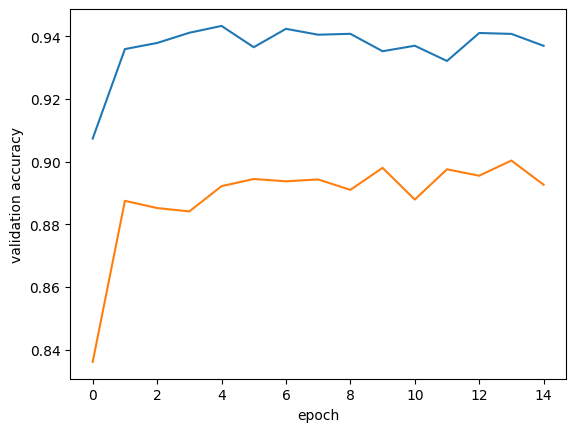

In [44]:
plt.plot(history.history["val_accuracy"])
plt.plot(history2.history["val_accuracy"])
plt.ylabel("validation accuracy")
plt.xlabel("epoch")
plt.show()

In [169]:
model.save("link_prediction2.keras")

In [197]:
model2.save("link_prediction_No_dates.keras")

In [38]:
x_test2 = x_test.copy()

for i in range(x_test2.shape[0]):
    x_test2[i, 100] = 0
    x_test2[i, 101] = 0
    x_test2[i, 202] = 0
    x_test2[i, 203] = 0
loss, accuracy_no_dates = model2.evaluate(x_test2, y_test)

1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9214 - loss: 0.1940


In [39]:
print(accuracy_no_dates)

0.8926670551300049


In [28]:
loss, accuracy = model.evaluate(x_test, y_test)

1316/1316 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9402 - loss: 0.1574


In [173]:
print(accuracy)

0.9411652684211731


In [30]:
edges = list(graph.edges())

In [45]:
for edge in edges:
    if edge[0] == edge[1]:
        print((edge[0], edge[1]))

(2193, 2193)
(6056, 6056)
(102122, 102122)
(108195, 108195)
(111193, 111193)
(201248, 201248)
(201291, 201291)
(9312343, 9312343)
(9502380, 9502380)
(9605228, 9605228)
(9610527, 9610527)
(9612326, 9612326)
(9701288, 9701288)
(9705442, 9705442)
(9707481, 9707481)
(9803242, 9803242)
(9809337, 9809337)
(9907261, 9907261)


In [31]:
edge = edges[0]
edge

(1001, 9212308)

In [179]:
list(time_graph.nodes())[:20]

[1001,
 1002,
 1003,
 111002,
 1004,
 1008,
 1009,
 1005,
 1011,
 1013,
 1015,
 1019,
 111019,
 1021,
 1028,
 1031,
 1032,
 1034,
 1035,
 1037]

In [180]:
graph.has_edge(111002, 111002)

False

In [47]:
model.predict(np.expand_dims(edge_to_vec((102122, 102122)), axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[0.01094395]], dtype=float32)

In [17]:

model_load = tf.keras.models.load_model("/kaggle/input/linkprediction1/tensorflow2/default/1/link_prediction.keras")

In [18]:
loss, accuracy = model_load.evaluate(x_test, y_test)

I0000 00:00:1731707301.981504     196 service.cc:145] XLA service 0x7ea2ec005370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731707301.981558     196 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731707301.981564     196 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 118/1316 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 5.0651e-04 - loss: 3.9561

I0000 00:00:1731707302.612362     196 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1316/1316 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6139 - loss: 1.4063


In [19]:
accuracy

0.8397966027259827